In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [3]:
import allel
import numpy as np
import pandas as pd
import seaborn as sns
import umap

## PCA using sci-kit learn

### PCA using vcf files

Loading in the vcf files as well as the metadata file

In [4]:
chr7_females = allel.read_vcf('../steps/recode_vcf/chr7_females.recode.vcf')

In [5]:
chrX_females = allel.read_vcf('../steps/recode_vcf/chrX_females.recode.vcf')

In [6]:
chr7_males = allel.read_vcf('../steps/recode_vcf/chr7_males.recode.vcf')

In [7]:
chrX_males = allel.read_vcf('../../../../data/haploidified_chrX_males/hap_chrX_males.vcf.gz')

In [8]:
meta_data_samples = pd.read_table("../data/metadata_erik.txt", sep=" ")

In [9]:
meta_data_females = meta_data_samples[meta_data_samples['Sex'] == 'F']
meta_data_males = meta_data_samples[(meta_data_samples['Sex'] == 'M') & (meta_data_samples['Genus'] == 'Papio')]

Function for converting vcf file into df to be used for PCA.

In [10]:
def vcf2df(vcf):
    gt = allel.GenotypeArray(vcf['calldata/GT'])
    ac = gt.count_alleles()
    
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gt.compress(flt, axis=0)
    
    gn = gf.to_n_alt()
    
    return gn

Function for pruning the df.

In [11]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

Function for performing PCA analysis.

In [12]:
def perform_pca(df, vcf, components, pop_df):
    pipeline = make_pipeline(StandardScaler(), sklearnPCA(n_components=components))
    data_transf = pipeline.fit_transform(df.T)
    
    principal_df = pd.DataFrame(data = data_transf, 
                                columns = ['PC{}'.format(i) for i in range(1, components + 1)],
                                index=vcf['samples'])
    
    pop_df = pop_df.set_index('PGDP_ID')
    
    final_df = pd.merge(principal_df, pop_df['C_origin'], left_index=True, right_index=True)

    pca = pipeline.get_params()['pca']
    
    return final_df, pca

Function for plotting two pcs.

In [50]:
def plot_pca(df, pca, pop, chrom, pc_xaxis, pc_yaxis):
    pc1_var = (pca.explained_variance_ratio_[pc_xaxis-1]*100).round(decimals=2)
    pc2_var = (pca.explained_variance_ratio_[pc_yaxis-1]*100).round(decimals=2)
    
    fig, ax = plt.subplots(figsize = (6,5))
    
    groups = df.groupby('C_origin')
    for name, group in groups:
        ax.scatter(group['PC{}'.format(pc_xaxis)], group['PC{}'.format(pc_yaxis)], label=name)
        
    ax.set_xlabel('Principal Component {} ({}%)'.format(pc_xaxis, pc1_var), fontsize = 10)
    ax.set_ylabel('Principal Component {} ({}%)'.format(pc_yaxis, pc2_var), fontsize = 10)
    ax.set_title('{} (chromosome {})'.format(pop, chrom), fontsize = 15)
    ax.legend(bbox_to_anchor=(1.01, 0.75))
    
#     fig.tight_layout()
    plt.show()
#     fig.savefig('../figures/PC{}_{}_{}_{}.pdf'.format(pc_xaxis, pc_yaxis, pop, chrom), bbox_inches='tight')

Function for plotting the variance explained ratio of each of the pcs.

In [14]:
def var_expl(pca):
    fig, ax = plt.subplots(figsize = (6,5))
    
    ax.bar(x = range(1, 11), height = pca.explained_variance_ratio_)
    
    ax.set_xlabel('Principal Components', fontsize = 10)
    ax.set_ylabel('Variance explained', fontsize = 10)
    ax.set_title('Distribution of variance explained', fontsize = 15)
    ax.set_ylim(0, max(pca.explained_variance_ratio_)*2)

    plt.show()

#### Females
##### Chromosome 7

In [15]:
females_7 = vcf2df(chr7_females)

In [16]:
pruned_females_7 = ld_prune(females_7, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 333530 removing 2616101 variants


In [17]:
pca_chr7_females = perform_pca(pruned_females_7, chr7_females, 10, meta_data_females)

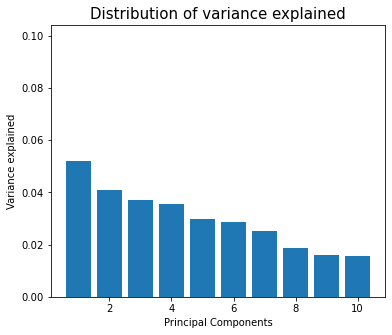

In [18]:
var_expl(pca_chr7_females[1])

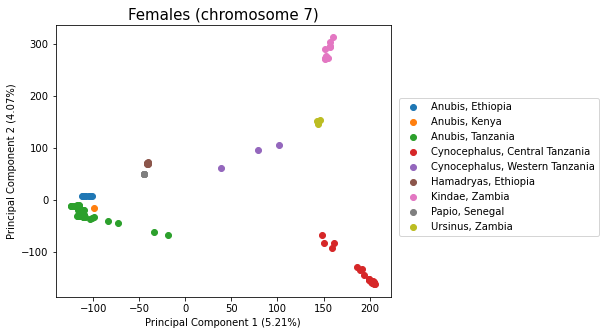

In [19]:
plot_pca(pca_chr7_females[0], pca_chr7_females[1], 'Females', 7, 1, 2)

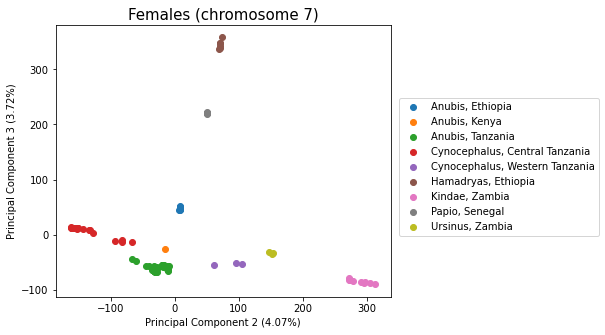

In [20]:
plot_pca(pca_chr7_females[0], pca_chr7_females[1], 'Females', 7, 2, 3)

##### Chromosome X

In [21]:
females_X = vcf2df(chrX_females)

In [22]:
pruned_females_X = ld_prune(females_X, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 164066 removing 1423559 variants


In [23]:
pca_chrX_females = perform_pca(pruned_females_X, chrX_females, 10, meta_data_females)

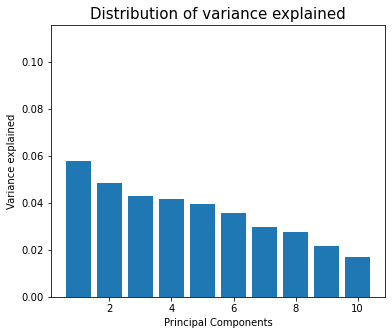

In [24]:
var_expl(pca_chrX_females[1])

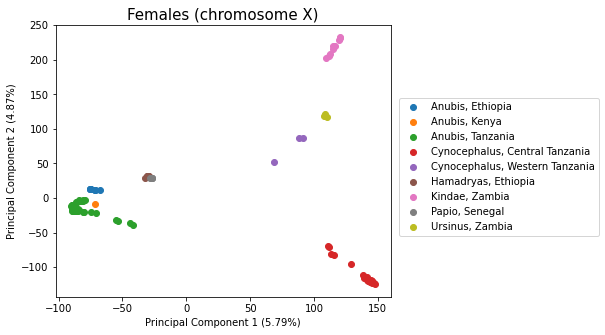

In [25]:
plot_pca(pca_chrX_females[0], pca_chrX_females[1], 'Females', 'X', 1, 2)

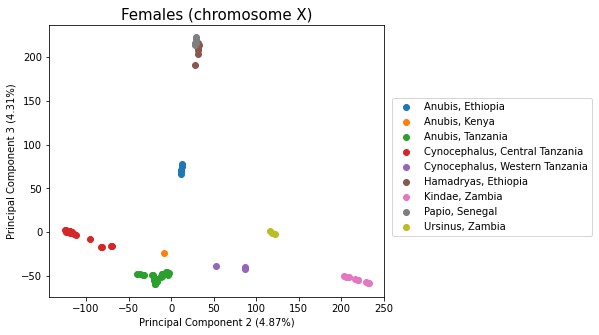

In [26]:
plot_pca(pca_chrX_females[0], pca_chrX_females[1], 'Females', 'X', 2, 3)

#### Males
##### Chromosome 7

In [27]:
males_7 = vcf2df(chr7_males)

In [28]:
pruned_males_7 = ld_prune(males_7, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 443737 removing 2890829 variants


In [29]:
pca_chr7_males = perform_pca(pruned_males_7, chr7_males, 10, meta_data_males)

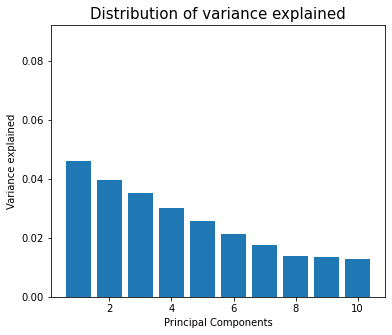

In [30]:
var_expl(pca_chr7_males[1])

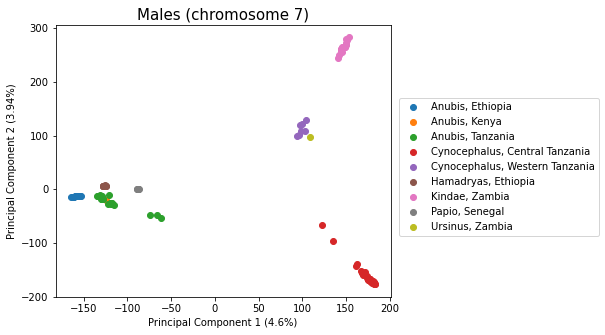

In [31]:
plot_pca(pca_chr7_males[0], pca_chr7_males[1], 'Males', 7, 1, 2)

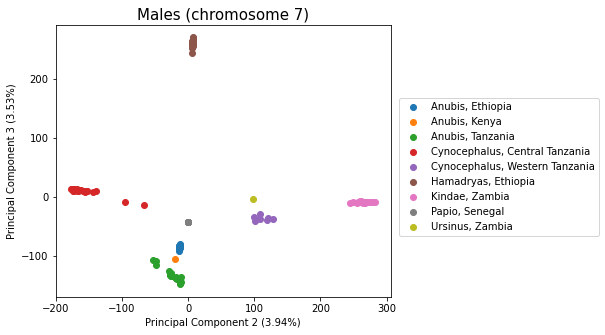

In [32]:
plot_pca(pca_chr7_males[0], pca_chr7_males[1], 'Males', 7, 2, 3)

##### Chromosome X

In [33]:
males_X = vcf2df(chrX_males)

In [34]:
pruned_males_X = ld_prune(males_X, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 146419 removing 1245718 variants


In [35]:
pca_chrX_males = perform_pca(pruned_males_X, chrX_males, 10, meta_data_males)

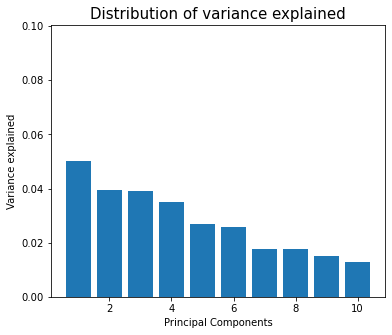

In [36]:
var_expl(pca_chrX_males[1])

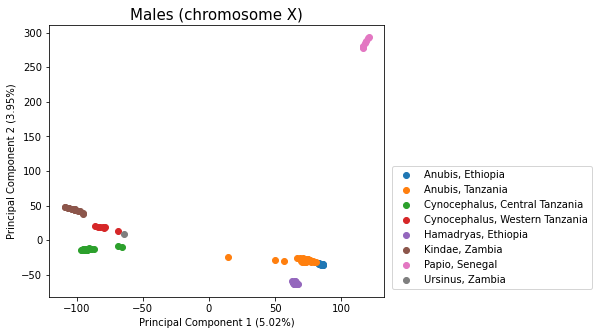

In [48]:
plot_pca(pca_chrX_males[0], pca_chrX_males[1], 'Males', 'X', 1, 2)

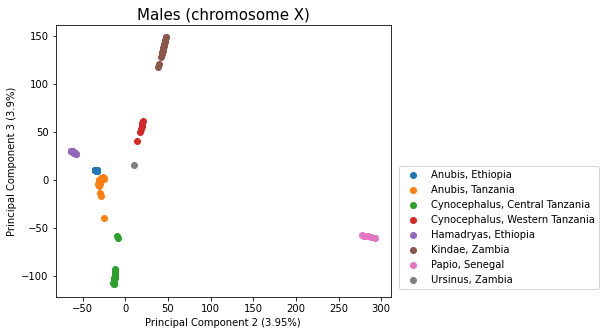

In [49]:
plot_pca(pca_chrX_males[0], pca_chrX_males[1], 'Males', 'X', 2, 3)

### PCA using chromopainter output

In [39]:
def plot_fs_pca(df, pca, pc_xaxis, pc_yaxis):
    pc1_var = (pca.explained_variance_ratio_[pc_xaxis-1]*100).round(decimals=2)
    pc2_var = (pca.explained_variance_ratio_[pc_yaxis-1]*100).round(decimals=2)

    fig, ax = plt.subplots(figsize = (6,5))

    groups = df.groupby('C_origin')
    for name, group in groups:
        ax.scatter(group['PC{}'.format(pc_xaxis)], group['PC{}'.format(pc_yaxis)], label=name)

    ax.set_xlabel('Principal Component {} ({}%)'.format(pc_xaxis, pc1_var), fontsize = 10)
    ax.set_ylabel('Principal Component {} ({}%)'.format(pc_yaxis, pc2_var), fontsize = 10)
    ax.set_title('PC{} & PC{}'.format(pc_xaxis, pc_yaxis), fontsize = 15)
    ax.legend(bbox_to_anchor=(1.01, 0.75))

#     fig.tight_layout()
    plt.show()

In [40]:
fs_out = pd.read_table("../steps/finestructure/test_run_linked.chunkcounts.out", sep=" ", header = 1, index_col = 0)

In [41]:
fs_males = perform_pca(fs_out, chrX_males, 10, meta_data_males) 

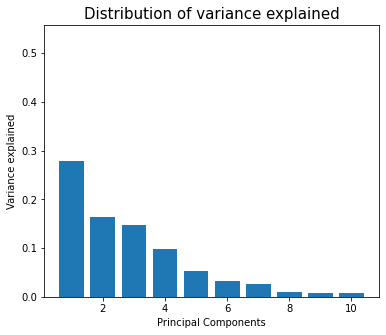

In [42]:
var_expl(fs_males[1])

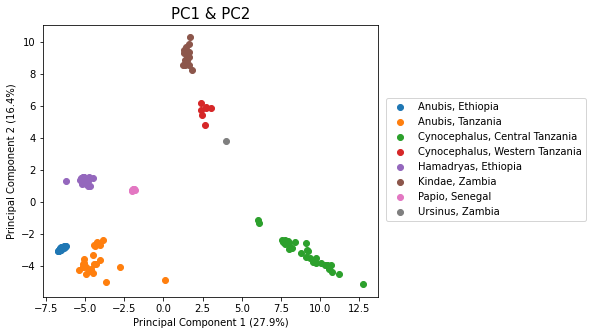

In [43]:
plot_fs_pca(fs_males[0], fs_males[1], 1, 2)

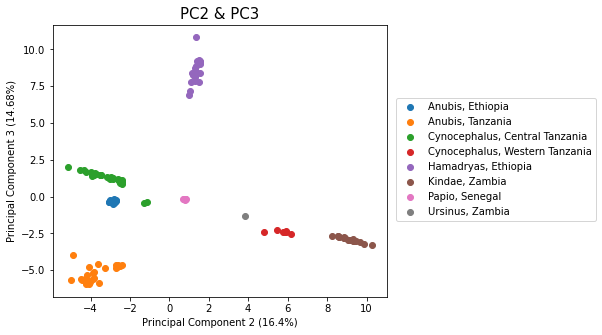

In [51]:
plot_fs_pca(fs_males[0], fs_males[1], 2, 3)

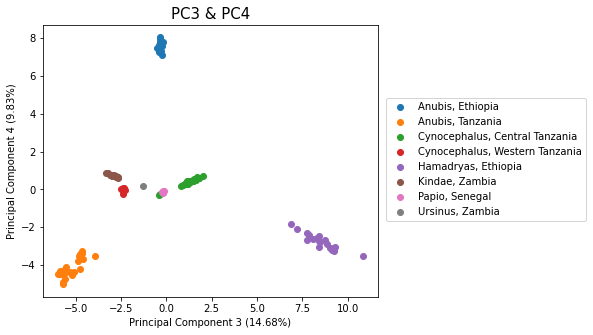

In [52]:
plot_fs_pca(fs_males[0], fs_males[1], 3, 4)